Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Starting forward filtering...
Forward filtering completed.
Starting forward filtering...
Forward filtering completed.
Validation RMSE: 1383.7532561061455
Testing RMSE: 8.495722785712807
MAE: 7.390376209075632
MAPE: 49.510778046512605


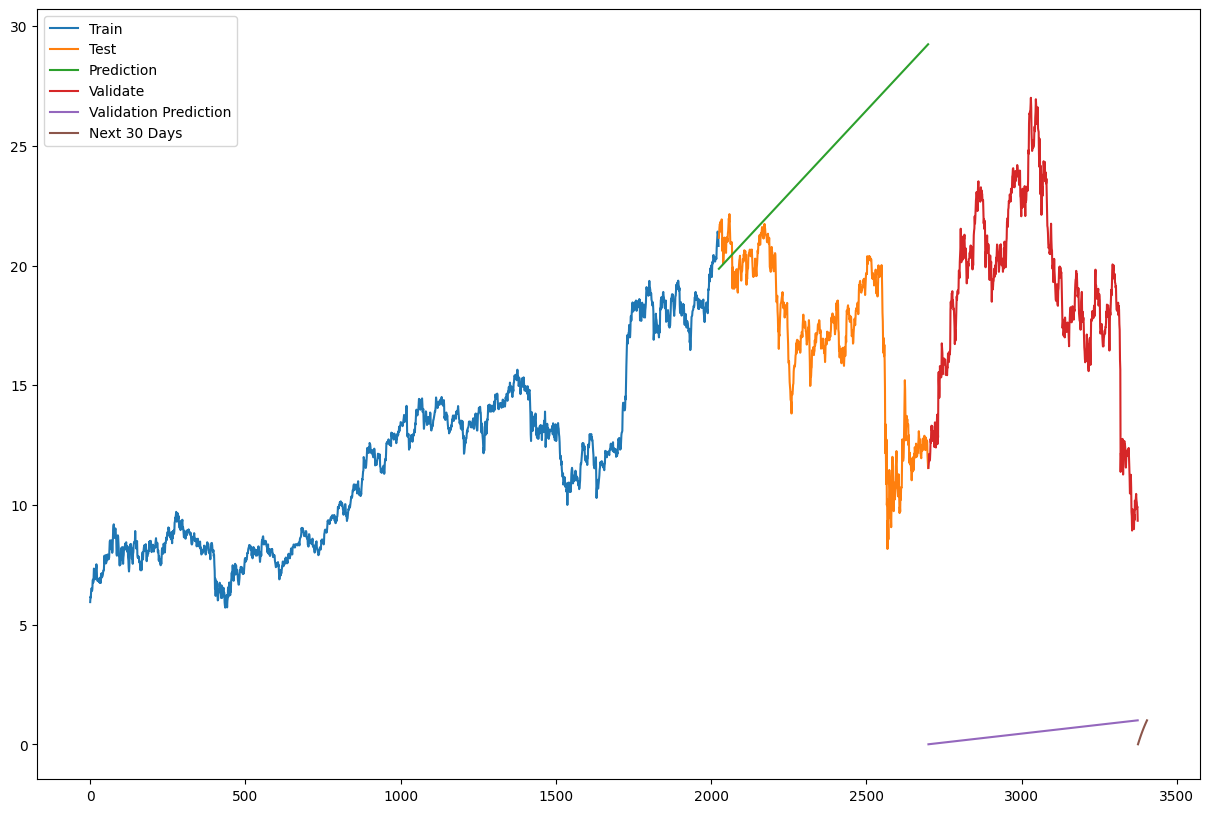

In [1]:
import pandas as pd
import numpy as np
from pydlm import dlm, trend
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Đọc dữ liệu từ file
df = pd.read_csv('E:/Nam3/HK2/Business_Analyst/github/BDLM/Bayesian_Dynamic_linear_Model/dataset/KEY.csv')
df = df[['Close']]
df = df.dropna()
df = df.reset_index(drop=True)

# Chia dữ liệu thành tập train, test và validate
train_size = int(0.6 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close']).reshape(-1, 1)

# Tạo mô hình Bayesian Dynamic Linear Model
dlm_model = dlm(y_train)
dlm_model = dlm_model + trend(1, name='linear_trend')

# Huấn luyện mô hình
dlm_model.fit()

# Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close']).reshape(-1, 1)
num_days = len(test_data)  # Number of days to predict
(predicted_test, _) = dlm_model.predictN(N=num_days)

# Cập nhật mô hình với dữ liệu test
for i in range(len(x_test)):
    dlm_model.append([x_test[i]])
    dlm_model.append([y_test[i]])

dlm_model.fitForwardFilter()  # Perform forward filtering

# Quá trình Validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close']).reshape(-1, 1)
(predicted_val, _) = dlm_model.predictN(N=len(val_data))

# Quá trình tạo index predict 30 ngày tiếp theo
last_index = df.index[-1]
x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)

# Append future dates to the model
for i in range(len(x_next_30_days)):
    dlm_model.append([x_next_30_days[i]])

dlm_model.fitForwardFilter()  # Perform forward filtering

# Dự đoán 30 ngày tiếp theo
predicted_next_30 = []
for i in range(30):
    date = x_next_30_days[i][0]  # Extract the single value from the array
    (predicted_obs, _) = dlm_model.predict(date=date)
    predicted_next_30.append(predicted_obs[0])

predicted_next_30 = np.array(predicted_next_30).reshape(-1, 1)  # Reshape to match x_next_30_days

# 8. Tính RMSE

valid_rmse = np.sqrt(np.mean((predicted_val - y_val) ** 2))
test_rmse = np.sqrt(np.mean((predicted_test - y_test) ** 2))
mae = np.mean(np.abs(predicted_test - y_test))
mape = np.mean(np.abs((predicted_test - y_test) / y_test)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('MAE:', mae)
print('MAPE:', mape)

# Vẽ hình
plt.figure(figsize=(15, 10))
plt.plot(train_data.index, train_data['Close'], label='Train')
plt.plot(test_data.index, test_data['Close'], label='Test')
plt.plot(test_data.index, predicted_test, label='Prediction')
plt.plot(val_data.index, val_data['Close'], label='Validate')

scaled_predicted_val = (predicted_val - np.min(predicted_val)) / (np.max(predicted_val) - np.min(predicted_val))
scaled_predicted_next_30 = (predicted_next_30 - np.min(predicted_next_30)) / (np.max(predicted_next_30) - np.min(predicted_next_30))

# Plot the scaled predicted values
plt.plot(val_data.index, scaled_predicted_val, label='Validation Prediction')
plt.plot(x_next_30_days, scaled_predicted_next_30, label='Next 30 Days')

plt.legend()
plt.show()
